Exercise 2: Bayesian A/B testing for Swedish Fish Incorporated with Stan 
============ 
### *Rasmus Bååth (adapted for Python by Christophe Carvenius)*
Swedish Fish Incorporated is the largest Swedish company delivering fish by mail order, but you probably already knew that. The marketing department have done a pilot study and tried two different marketing methods:

**A:** Sending a mail with a colorful brochure that invites people to sign up for a one year salmon subscription.

**B:** Sending a colorful brochure that invites people to sign up for a one year salmon subscription *and that includes a free salmon*.

The marketing department sent out 16 mails of type A and 16 mails of type B. Six Danes that received a mail of type A signed up for one year of salmon, and ten Danes that received a mail of type B signed up!

The marketing department now wants to know, which method should we use, A or B?

*At the bottom of this document you’ll find a solution. But try yourself first!*

## Question 1: Build a Bayesian model in Stan that answers the question: What is the probability that method B is better than method A?
**Hint 1:** As part of you generative model you’ll want to use the binomial distribution, which you can use in Stan like this:

`s ~ binomial(size, rate);`

This should be read as: The number of successes `s` is distributed as a binomial distribution with `size` trials, where the rate of success is `rate`.

**Hint 2:** A commonly used prior for the unknown probability of success in a binomial distribution is a uniform distribution from 0 to 1. You can use this distribution in Stan like this:

`rate ~  uniform(0, 1);`

**Hint 3:** Here is a code scaffold that you can build upon which estimates the rate for one group. For an A/B test you would have to extend this model to include two groups. Comparing the rates of the two groups can be done either in the `generated quantities` block in Stan or by post-processing the samples from the stan model.

In [ ]:
# Import libraries
import pystan # install with pip install pystan
import pandas as pd
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

# The Stan model as a string.
model_string = """
# Here we define the data we are going to pass into the model
data {
  int n; # Number of trials
  int s;  # Number of successes
}

# Here we define what 'unknowns' aka parameters we have.
parameters {
  real<lower=0, upper=1> rate;
}

# The generative model
model {
  rate ~ uniform(0, 1);
  s ~ binomial(n, rate);
}

# In the generated quantiles block you can calculate 'derivatives' of
# the parameters. Here is a silly example calculating the square of the 
# rate. Variables have to be defined before they are assigned to.
generated quantities {
  real rate_squared;
  rate_squared <- rate^2;
}
"""

data_list = dict(n = 16, s = 6)

# Compiling and producing posterior samples from the model.
stan_samples = pystan.stan(model_code = model_string, data = data_list)

# Plotting and summarizing the posterior distribution
print(stan_samples)
stan_samples.plot()

# Export the samples to a data.frame for easier handling.
posterior = pd.DataFrame(stan_samples.extract())

# Now we could, for example, calculate the probability that the rate is higher
# than, say, 20%
print(sum(posterior.rate > 0.2) / len(posterior.rate))

## Question 2: Change the model so that it uses a more informative prior. What is now the probability that method B is better than method A?
The marketing department are starting to believe that it was a fluke that such a large proportion of the Danes signed up. In all other European markets the proportion that signs up for a year of salmon is around 5% to 15%, even when given a free salmon. Use this information and make the priors in your model more informative.

**Hint 1:** This can be done in a million ways and there isn’t any “right” answer to this question. Just do something quick ’n dirty.

**Hint 2:** It would however be cool if you used a prior that wasn’t uniform. A good distribution, when crafting priors with support over [0, 1], is the beta distribution. You can sample from a beta distribution using `random.beta(alpha, beta, size = 1)` function in numpy, where `alpha` and `beta` defines the shape of the distribution.

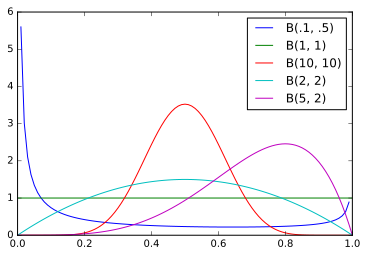

In [51]:
x = np.arange(0, 1.01, 0.01)

pd.DataFrame({'B(10, 10)' : beta.pdf(x, 10, 10),
                   'B(5, 2)' : beta.pdf(x, 5, 2),
                   'B(2, 2)' : beta.pdf(x, 2, 2),
                   'B(1, 1)' : beta.pdf(x, 1, 1),
                   'B(.1, .5)' : beta.pdf(x, .1, .5)}, index = x).plot()


**Hint 3:** An easy way to plot a beta distribution (and to explore what the shape parameters really do) is to run the following and to play around with shape1 and shape2:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11f2e3e48>]], dtype=object)

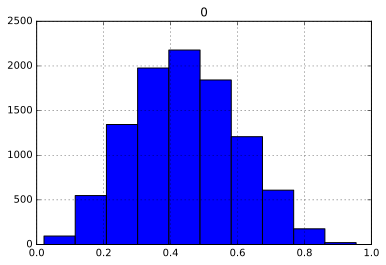

In [52]:
pd.DataFrame(np.random.beta(4, 5, size = 9999)).hist()

## Question 3: So what should we do? Make a simple decision analysis.

The economy department gives you the following information:

* A mail of type A costs 30 kr to send out.
* A mail of type B costs 300 kr to send out (due to the cost of the free salmon).
* A salmon subscription brings in 1000 kr in revenue.
**Which method, A or B, is most likely to make Swedish Fish Incorporated the most money?**

**Hint 1:** This should require no changes to your model. It should suffice to post process the samples.

**Hint 2:** If `rateA` is the probability that someone will sign up when receiving a type A mail then the expected profit is `1000 * prob_a - 30`

**Hint 3:** The cool thing with working with samples from posterior distributions is that if we calculate a ‘derivative’ per each row of the sample then the resulting 'derivative distribution' will be correct! That is the derived quantity `rate_squared` in the model scaffold given in question I could equally well be calulated after having run the model, like this:

`posterior = pd.DataFrame(stan_samples.extract())`

`rate_squared = posterior.rate**2`

Solutions (but this can be done in many ways)
==========
## Question I

Inference for Stan model: anon_model_528490c7c02220dbc5a4da271dc455d4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rateA       0.39  3.3e-3   0.11   0.18   0.31   0.38   0.46   0.62   1097    1.0
rateB       0.61  3.2e-3   0.11   0.38   0.54   0.62   0.69   0.81   1125    1.0
rate_diff   0.22  4.6e-3   0.15   -0.1   0.13   0.23   0.33   0.51   1119    1.0
lp__      -25.03    0.04   1.01  -27.8 -25.41 -24.72 -24.32 -24.08    730    1.0

Samples were drawn using NUTS(diag_e) at Tue Jan 19 16:16:49 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


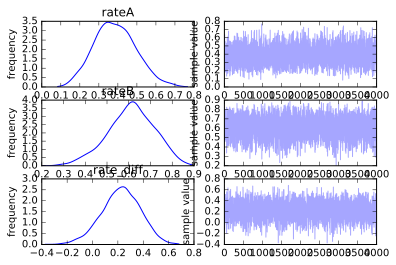

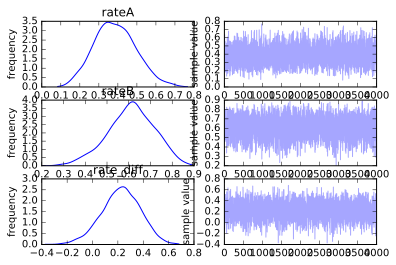

In [55]:
import pystan # install with pip install pystan
import pandas as pd
import numpy as np

# The Stan model as a string.
model_string = """
data {
  # Number of trials
  int nA;
  int nB;
  # Number of successes
  int sA;
  int sB;
}

parameters {
  real<lower=0, upper=1> rateA;
  real<lower=0, upper=1> rateB;
}

model {
  rateA ~ uniform(0, 1);
  rateB ~ uniform(0, 1);
  sA ~ binomial(nA, rateA);
  sB ~ binomial(nB, rateB); 
}

generated quantities {
  real rate_diff;
  rate_diff <- rateB - rateA;
}
"""

data_list = dict(nA = 16, nB = 16, sA = 6, sB = 10)

# Compiling and producing posterior samples from the model.
stan_samples = pystan.stan(model_code = model_string, data = data_list)
print(stan_samples)
stan_samples.plot()

So, which rate is likely higher? A or B?

In [65]:
# Export the samples to a data.frame for easier handling.
posterior = pd.DataFrame(stan_samples.extract())
np.mean(posterior.rate_diff > 0) # same as sum(posterior.rate_diff > 0) / len(posterior.rate_diff)

0.92374999999999996

So with around 90% probability rate B is higher than rate A. 

## Question II
There are an unlimited ways of doing this, and here I’m just going to go with something that I think is decent but surely not perfect.

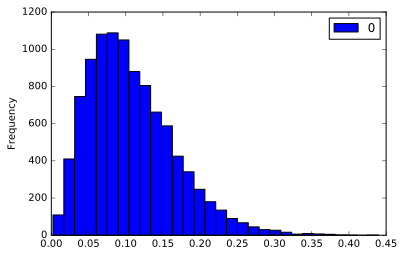

In [64]:
# We will represent the background knowledge using the following beta distribution 
# which is mostly focused on the region 0.05-0.15.

pd.DataFrame(np.random.beta(3, 25, size = 9999)).plot(kind = 'hist', bins = 30)

Inference for Stan model: anon_model_ac27ec68f8d20d39adb9d18118907ef6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rateA       0.21  1.8e-3   0.06    0.1   0.16    0.2   0.25   0.34   1130    1.0
rateB        0.3  2.1e-3   0.07   0.17   0.25   0.29   0.34   0.44   1101    1.0
rate_diff   0.09  2.9e-3   0.09  -0.09   0.03   0.09   0.15   0.27   1045    1.0
lp__      -50.06    0.04    1.0 -52.72  -50.5 -49.77 -49.33 -49.02    760   1.01

Samples were drawn using NUTS(diag_e) at Tue Jan 19 16:25:30 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


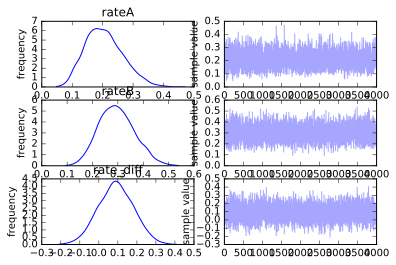

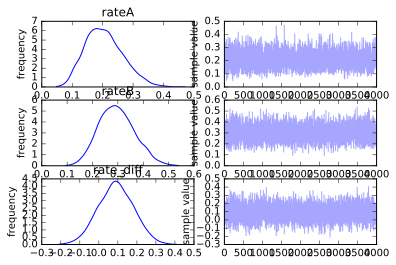

In [66]:
import pystan # install with pip install pystan
import pandas as pd
import numpy as np

# The Stan model as a string.
model_string = """
data {
  # Number of trials
  int nA;
  int nB;
  # Number of successes
  int sA;
  int sB;
}

parameters {
  real<lower=0, upper=1> rateA;
  real<lower=0, upper=1> rateB;
}

model {  
  rateA ~ beta(3, 25);
  rateB ~ beta(3, 25);
  sA ~ binomial(nA, rateA);
  sB ~ binomial(nB, rateB); 
}

generated quantities {
  real rate_diff;
  rate_diff <- rateB - rateA;
}
"""

data_list = dict(nA = 16, nB = 16, sA = 6, sB = 10)

# Compiling and producing posterior samples from the model.
stan_samples = pystan.stan(model_code = model_string, data = data_list)
print(stan_samples)
stan_samples.plot() # The Stan model as a string.

In [67]:
# Export the samples to a data.frame for easier handling.
posterior = pd.DataFrame(stan_samples.extract())
np.mean(posterior.rate_diff > 0) # same as sum(posterior.rate_diff > 0) / len(posterior.rate_diff)

0.82550000000000001

So rate B is still estimated to be higher than A with around
80% probability, but both rates are estimated to be much lower.


## Question III
Here we don’t have to make any changes to the model, it is enough to "post-process" the posterior distribution in posterior.

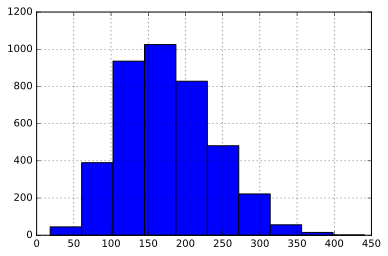

In [69]:
posterior = pd.DataFrame(stan_samples.extract())

# calculating the estimated posterior profit using method A (or B)
# a cost of 30 kr + the average profit per sent out add

profitA = -30 + posterior.rateA * 1000 
profitB = -300 + posterior.rateB * 1000 
profitA.hist()

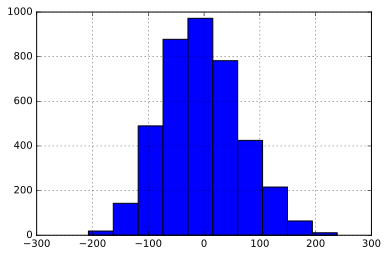

In [72]:
profitB.hist()

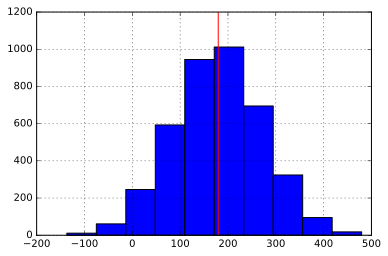

In [81]:
ax = (profitA - profitB).hist()
expected_profit_diff = np.mean(profitA - profitB)
ax.axvline(expected_profit_diff, color='r', linestyle='-')

The expected profit when using method A is around 190 kr higher than for method B (which actually has a negative expected profit). So I guess sending free salmon to people isn't the best idea… 